# Packages and Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Dataset

In [2]:
import cv2
import imghdr
import pathlib # For path 
import os

In [3]:
image_exts = ['jpeg','jpg', 'bmp', 'png']
data_dir = 'data'

## Remove unusable data

In [4]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data\Pinakbet\.ipynb_checkpoints
Issue with image data\Sinigang\.ipynb_checkpoints


In [5]:
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.*')))
print(f"Total number of images: {image_count}")

Total number of images: 2875


## Create dataset

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Training Dataset

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2876 files belonging to 3 classes.
Using 2301 files for training.


Validation Dataset

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2876 files belonging to 3 classes.
Using 575 files for validation.


Print Class

In [10]:
class_names = train_ds.class_names
print(class_names)

['Adobo', 'Pinakbet', 'Sinigang']


## Data Visualization

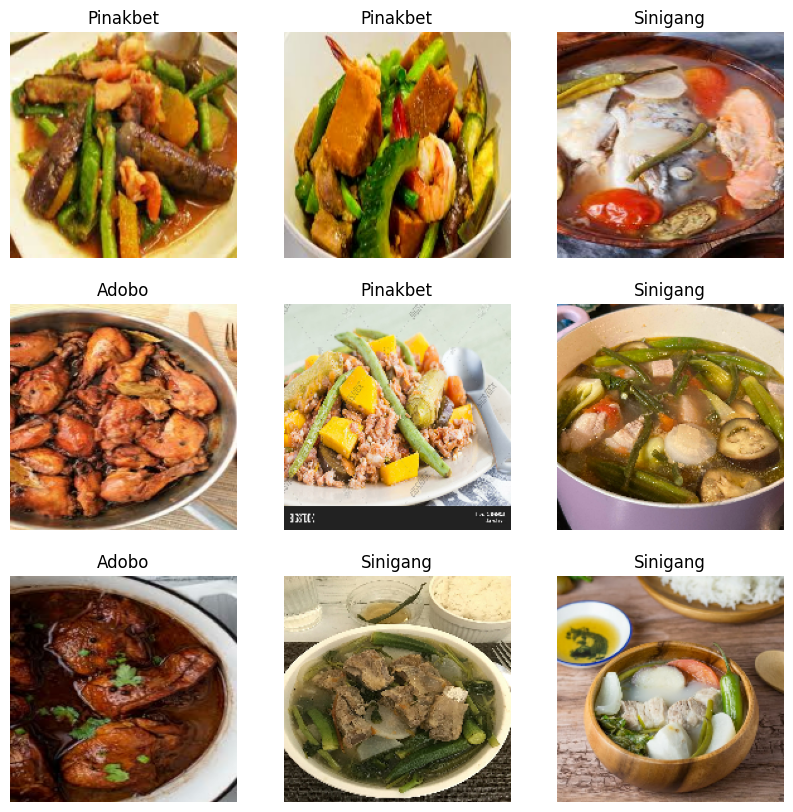

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Batch information

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure and Standardize the Dataset

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

## Create the Model

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the Model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
72/72 [==============================] - 38s 518ms/step - loss: 0.9809 - accuracy: 0.5432 - val_loss: 0.6999 - val_accuracy: 0.6817
Epoch 2/10
72/72 [==============================] - 34s 472ms/step - loss: 0.6568 - accuracy: 0.7179 - val_loss: 0.7744 - val_accuracy: 0.6870
Epoch 3/10
72/72 [==============================] - 34s 476ms/step - loss: 0.5091 - accuracy: 0.8049 - val_loss: 0.5559 - val_accuracy: 0.8000
Epoch 4/10
72/72 [==============================] - 36s 498ms/step - loss: 0.3838 - accuracy: 0.8566 - val_loss: 0.5273 - val_accuracy: 0.8139
Epoch 5/10
72/72 [==============================] - 38s 531ms/step - loss: 0.2299 - accuracy: 0.9196 - val_loss: 0.6743 - val_accuracy: 0.7913
Epoch 6/10
72/72 [==============================] - 37s 508ms/step - loss: 0.1336 - accuracy: 0.9570 - val_loss: 0.5826 - val_accuracy: 0.8278
Epoch 7/10
72/72 [==============================] - 40s 557ms/step - loss: 0.0819 - accuracy: 0.9744 - val_loss: 0.6455 - val_accuracy: 0.8452

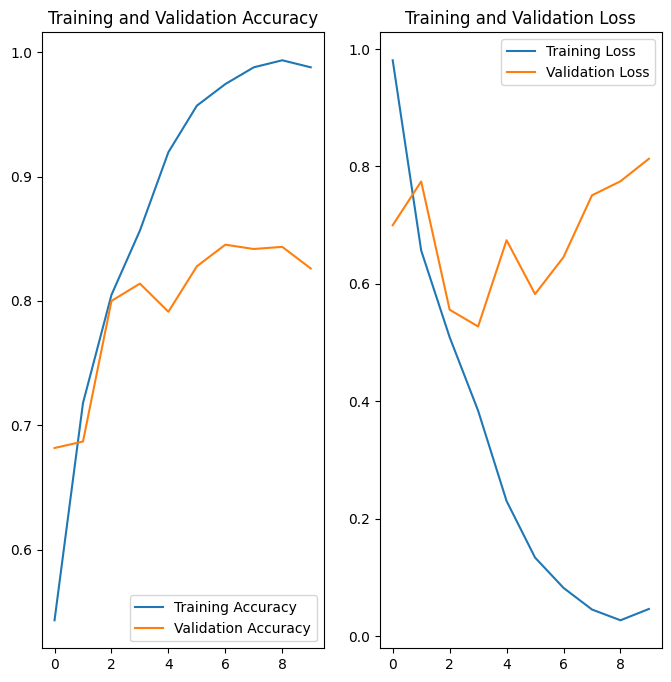

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
import cv2

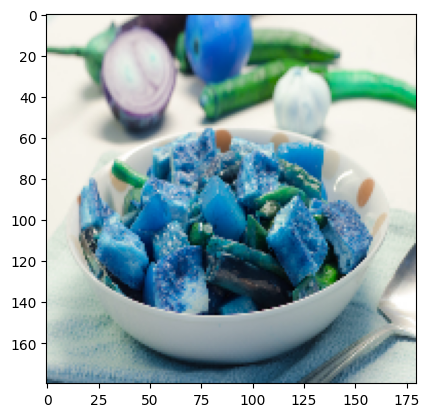

In [22]:
img = cv2.imread('pinakbet.jpg')

resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [23]:
predictions = model.predict(np.expand_dims(resize/255, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 196ms/step
This image most likely belongs to Adobo with a 100.00 percent confidence.


## Regularization (Prevent Overfitting)

### Data Augmentation

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

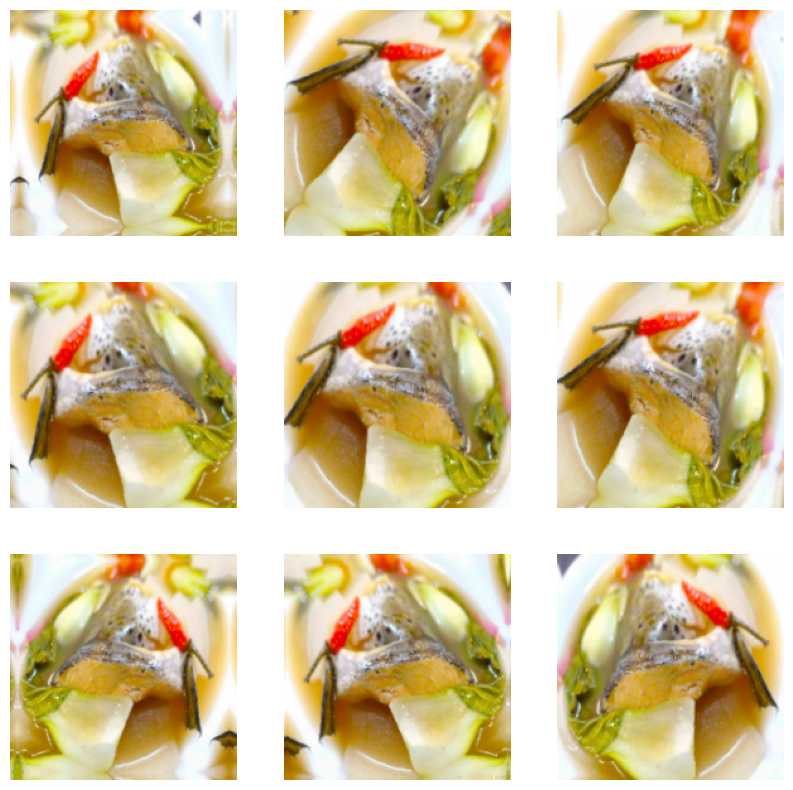

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [26]:
model = Sequential([
    data_augmentation,
    
    # Rescale the input pixels to the range [0, 1]
    layers.Rescaling(scale=1./255),
    
    # Use a pre-trained model as a starting point
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                   activation='elu', kernel_initializer='he_normal', trainable=True),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='elu', kernel_initializer='he_normal', trainable=True),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='elu', kernel_initializer='he_normal', trainable=True),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation='softmax', name="outputs")
])

NameError: name 'IMAGE_SIZE' is not defined

In [27]:
model = Sequential([
  data_augmentation,
    
  layers.Rescaling(1./255),
    
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
    
  layers.Dense(num_classes, name="outputs")
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)       

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
72/72 [==============================] - 64s 854ms/step - loss: 0.8482 - accuracy: 0.7206 - val_loss: 6.0246 - val_accuracy: 0.5357
Epoch 2/15
72/72 [==============================] - 60s 836ms/step - loss: 0.4602 - accuracy: 0.8140 - val_loss: 7.4768 - val_accuracy: 0.5635
Epoch 3/15
72/72 [==============================] - 62s 858ms/step - loss: 0.3904 - accuracy: 0.8561 - val_loss: 2.4714 - val_accuracy: 0.5948
Epoch 4/15
72/72 [==============================] - 62s 867ms/step - loss: 0.3340 - accuracy: 0.8748 - val_loss: 1.6576 - val_accuracy: 0.5896
Epoch 5/15
72/72 [==============================] - 61s 842ms/step - loss: 0.2753 - accuracy: 0.9009 - val_loss: 1.2828 - val_accuracy: 0.6574
Epoch 6/15
72/72 [==============================] - 61s 849ms/step - loss: 0.2339 - accuracy: 0.9170 - val_loss: 1.0534 - val_accuracy: 0.6974
Epoch 7/15
72/72 [==============================] - 61s 845ms/step - loss: 0.2207 - accuracy: 0.9248 - val_loss: 0.6128 - val_accuracy: 0.8000

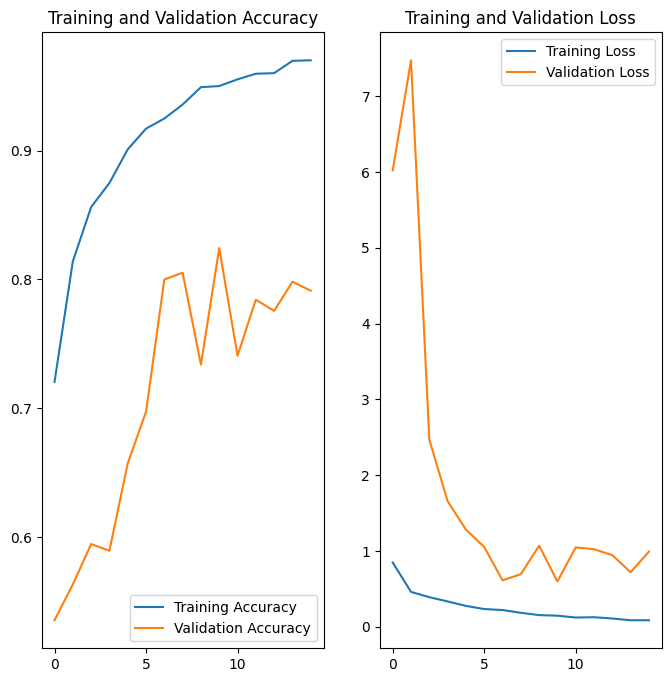

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

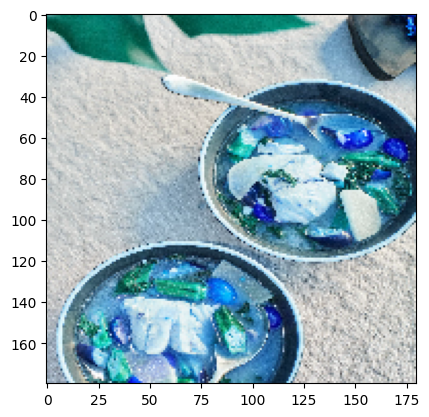

In [47]:
import cv2
img = cv2.imread('adobo.jpg')

resize = tf.image.resize(img, (180, 180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
predictions = model.predict(np.expand_dims(resize/180, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 77ms/step
This image most likely belongs to Adobo with a 82.09 percent confidence.
